In [1]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(1337)

Using TensorFlow backend.


In [2]:
def load_data(seq_len, shift_days = 1, normalize = True):
    
    result = []
    
    for index in range(len(data) - (seq_len+shift_days)):              # loop over all possible sequences by the sliding window
        result.append(data[index: index + seq_len + shift_days])       
    
    if normalize:
        result = normalise_windows(result)      # Normalizes one time series

    result = np.array(result)                   # convert list to array

    row = int(round(0.9 * result.shape[0]))   # 90% training data
    
    train = result[:row, :]                 # training set
    
    np.random.shuffle(train)
    
    x_train = train[:, :-shift_days]                # all the time series sequence except for last value for each seq           
    y_train = train[:, -shift_days:]                 # value following the end of the sliding window
    
    x_test = result[row:, :-shift_days]             # testing set
    y_test = result[row:, -shift_days:]
    
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1])) # reshape to 3d tensor for keras
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1]))     # reshape to 3d tensor for keras

    return x_train, y_train, x_test, y_test

In [3]:
""" Normalizes each windowed series of the data one at a time """
def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

def denormalise(window_data, p_0):
    denormalised_data = []
    for window in window_data:
        denormalised_window = [(p_0 *(n+1)) for n in window]
        denormalised_data.append(denormalised_window)
    return denormalised_data

  Effective date   S&P 500 (TR)  S&P 500 (Net TR)  S&P 500
0      2008-11-28       1437.68           1366.39   896.24
1      2008-12-01       1309.39           1244.44   816.21
2      2008-12-02       1361.79           1294.21   848.81
3      2008-12-03       1397.72           1328.14   870.74
4      2008-12-04       1356.81           1289.26   845.22


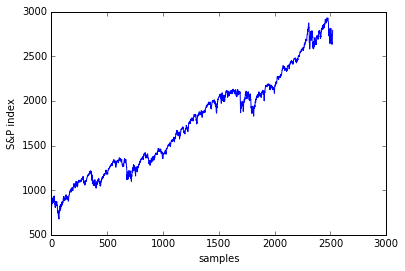

In [4]:
data  = pd.read_excel("data.xls", sheet_name= 'sheet2')    # reads excel to pandas dataframe
print(data.head())
data = np.array(data['S&P 500']).reshape(len(data),-1)    # Extract S&P column 
plt.plot(np.arange(len(data)),data)
plt.ylabel('S&P index')
plt.xlabel('samples')
plt.show()

In [5]:
seq_length = 50
x_train, y_train, x_test, y_test = load_data(seq_length, True)

In [6]:
print("X train: ", x_train.shape)
print("Y train: ", y_train.shape)
print("X test: ", x_test.shape)
print("Y test: ", y_test.shape)

('X train: ', (2223, 50))
('Y train: ', (2223, 1))
('X test: ', (247, 50))
('Y test: ', (247, 1))


In [19]:
model = Sequential()
model.add(Dense(50, input_dim=seq_length, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(optimizer="adam", loss="mean_squared_error")
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_14 (Dense)             (None, 25)                1275      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 26        
Total params: 3,851
Trainable params: 3,851
Non-trainable params: 0
_________________________________________________________________


In [20]:
#Step 3 Train the model
history = model.fit(
    x_train,
    y_train,
    batch_size=32,
    epochs=100,
    validation_split=0.05)

Train on 2111 samples, validate on 112 samples
Epoch 1/100
2111/2111 [==============================] - 0s 160us/step - loss: 0.0011 - val_loss: 3.7833e-04
Epoch 2/100
2111/2111 [==============================] - 0s 46us/step - loss: 2.5333e-04 - val_loss: 2.3168e-04
Epoch 3/100
2111/2111 [==============================] - 0s 44us/step - loss: 1.8591e-04 - val_loss: 2.3924e-04
Epoch 4/100
2111/2111 [==============================] - 0s 44us/step - loss: 1.6576e-04 - val_loss: 1.8848e-04
Epoch 5/100
2111/2111 [==============================] - 0s

In [22]:
result = model.evaluate(x_test,y_test)
print("mean_squared_error: ", result)

247/247 [==============================] - 0s 27us/step
('mean_squared_error: ', 0.00012427767643729518)


In [23]:
p = model.predict(x_test)

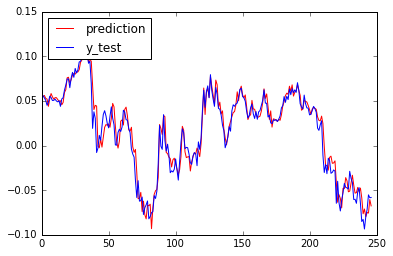

In [24]:
plt.plot(p,color='red', label='prediction')
plt.plot(y_test,color='blue', label='y_test')
plt.legend(loc='upper left')
plt.show()

**Training and validation losses**

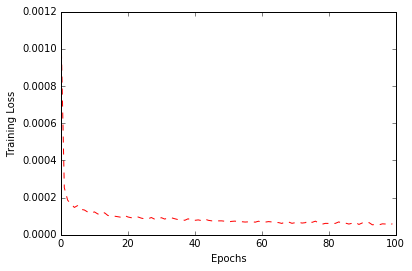

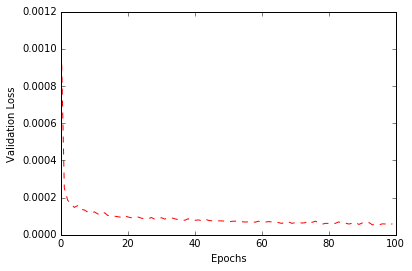

In [25]:
import keras
val_loss= history.history['val_loss']
train_loss= history.history['loss']
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
x = np.arange(len(train_loss))
plt.plot(x, train_loss, 'r--')
plt.show()

plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
x = np.arange(len(val_loss))
plt.plot(x, train_loss, 'r--')
plt.show()

*** Predict S&P index 5 days ***

In [27]:
from numpy import newaxis

days = 5                                         # Prediction length
x_before = data[-seq_length:]                                                 # Time series before predictions
p_0 = x_before[0]
x_before_normalized = np.array(normalise_windows([x_before]))
x_before_normalized = np.reshape(x_before_normalized,(x_before_normalized.shape[0], x_before_normalized.shape[1], 1)) # reshape to 3d tensor for keras
curr_frame = x_before_normalized[0]
pred_normal = []
pred = []
for i in range(days):
    
    p = model.predict(curr_frame.reshape(curr_frame.shape[1], -1))[0,0]        
    pred_normal.append(p)                                  # normalized value                          
    curr_frame = curr_frame[1:]                            # shift frame by 1 
    curr_frame = np.insert(curr_frame, seq_length-1, pred_normal[-1], axis=0)  # append the predicted value to the shifted time series
    frame_denormal = np.array(denormalise(curr_frame ,p_0)).reshape(curr_frame.shape) # rescale curr frame
    pred.append(frame_denormal[-1])                                                   # predicted value rescaled
    curr_frame = np.array(normalise_windows(frame_denormal[newaxis,:,:])).reshape(curr_frame.shape)  # scale current frame again
    p_0 = frame_denormal[0]        # save the value of the denormalized frame for next iteration

In [28]:
for i in range (days): 
    print("Day ",i ," : ", pred[i])

('Day ', 0, ' : ', array([2781.6797006]))
('Day ', 1, ' : ', array([2741.00386693]))
('Day ', 2, ' : ', array([2694.90893523]))
('Day ', 3, ' : ', array([2679.95422681]))
('Day ', 4, ' : ', array([2691.74533757]))
